# Cape Town Air BNB Prices #

## 1. Import Libraries and Read in Data

In [62]:
import pandas as pd
pd.set_option('display.max_columns', 300)

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')   
import scipy.stats as stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
from geopy.distance import great_circle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot


In [84]:
# Read in data 

listing_df = pd.read_csv('listings.csv')

In [64]:
# Read in crime statistics data to compliment neighbourhoods

crime_df = pd.read_csv('SA_crime_ward.csv')

In [65]:
#drop the nan row (was originally a double of column names not values)

crime_df.drop(111, inplace = True)

In [66]:
crime_df['geo_code'].astype(int)

0        1
1        2
2        3
3        4
4        5
      ... 
106    107
107    108
108    109
109    110
110    111
Name: geo_code, Length: 111, dtype: int64

In [67]:
crime_df.head()

,geo_level,geo_code,0_14,15_24,25_34,35_44,45_54,55_64,65+,total_raw,total_10000 _rounded
0,ward,1.0,33.0,249.0,504.0,276.0,153.0,63.0,39.0,1317.0,188.0
1,ward,2.0,27.0,249.0,408.0,282.0,174.0,69.0,39.0,1248.0,178.0
2,ward,3.0,33.0,243.0,417.0,258.0,132.0,57.0,51.0,1191.0,170.0
3,ward,4.0,39.0,306.0,447.0,309.0,180.0,132.0,90.0,1503.0,215.0
4,ward,5.0,33.0,90.0,282.0,132.0,126.0,72.0,60.0,795.0,114.0


In [68]:
listing_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,3191,Malleson Garden Cottage,3754,Brigitte,NaN,Ward 57,-33.94739,18.47600,Entire home/apt,819,3,54,2020-03-07,0.63,1,362
1,15007,Blaauwberg House,59072,Dirk,NaN,Ward 23,-33.80001,18.46063,Entire home/apt,2050,2,27,2019-08-18,0.34,4,251
2,15068,Grande Bay,59318,Linda,NaN,Ward 23,-33.78799,18.46082,Entire home/apt,2804,4,0,NaN,NaN,10,365
3,15077,Top relaxed beach living in style,59342,Georg,NaN,Ward 4,-33.85812,18.49043,Private room,1620,5,5,2016-12-10,0.06,5,208
4,15180,The Melkbaai - Beachfront,59663,Heinri,NaN,Ward 83,-34.11124,18.82349,Entire home/apt,575,2,0,NaN,NaN,1,365


## 2. Clean the data. 

In [85]:
# Dealing with NAs starting with Listing DataFrame
listing_df.isna().sum()

id                                    0
name                                  0
host_id                               0
host_name                             3
neighbourhood_group               24079
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                        6823
reviews_per_month                  6823
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [86]:
# Because the data set is over 24k, I decided to drop the nan values of reviews and last review (the same rows were nan for each)
# In researching SA Cape Town Air BNB, I found that houses with no reviews tended to have been expensive, but never booked
# Dropping these values, I expect to increase accuracy as some houses with massive price tags have never been booked or reviewed

listing_df.dropna(subset = ['reviews_per_month', 'last_review'], axis = 0, inplace = True)

In [87]:
# Testing for listings with price = 0
# Closed listing does not exist 9775 is 20685098 and it is listed as price = 0 

listing_df[listing_df.price == 0.0]
listing_df.drop(9775, inplace = True)

In [89]:
#listing append 9808 is 20736711 price was 0.0 is actually 121 USD, minimum night 7

listing_df.at[9808, 'price_usd'] = 121
listing_df.at[9808, 'minimum_nights'] = 7

In [88]:
# Seemingly half of the rates were in ZAR and half in dollars (lower cost was in USD)
# Air BNB zar conversion rate is 14.3 (current rate is 16.5)
# The most expensive house I could find was 3,000 that had been reviewed once/had been booked

listing_df['price_usd'] = listing_df.price.apply(lambda x: x/14.23 if x>= 3000 else x)

In [90]:
#minimum nights is 1125, which while this is true on airbnb, this place has not been booked at this minimum night and I believe it would scew the data. 

listing_df.drop(4957, inplace = True)

In [91]:
# Splitting by room type by making dummy binomial variables

listing_df = pd.get_dummies(listing_df, columns=['room_type'])

In [92]:
# Neighbourhoods

listing_df.neighbourhood = listing_df.neighbourhood.map(lambda x: x.replace('Ward', ''))

In [93]:
listing_df.neighbourhood = listing_df.neighbourhood.astype(int)

In [115]:
# Merge df on geo code/neighbourhood for the crime stats

listing_df = listing_df.merge(crime_df, left_on='neighbourhood', right_on = 'geo_code' ,how='left')
listing_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_usd,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,geo_level_x,geo_code_x,0_14_x,15_24_x,25_34_x,35_44_x,45_54_x,55_64_x,65+_x,total_raw_x,total_10000 _rounded_x,price_usd_log,distance_cc,distance_waterfront,distance_wine,distance_airport,geo_level_y,geo_code_y,0_14_y,15_24_y,25_34_y,35_44_y,45_54_y,55_64_y,65+_y,total_raw_y,total_10000 _rounded_y
0,3191,Malleson Garden Cottage,3754,Brigitte,NaN,57,-33.94739,18.47600,819,3,54,2020-03-07,0.63,1,362,819.000000,1,0,0,0,ward,57.0,24.0,219.0,456.0,432.0,303.0,141.0,120.0,1695.0,242.0,6.708084,3.356482,4.390745,22.826170,3.356482,ward,57.0,24.0,219.0,456.0,432.0,303.0,141.0,120.0,1695.0,242.0
1,15007,Blaauwberg House,59072,Dirk,NaN,23,-33.80001,18.46063,2050,2,27,2019-08-18,0.34,4,251,2050.000000,1,0,0,0,ward,23.0,39.0,270.0,357.0,210.0,153.0,42.0,30.0,1101.0,157.0,7.625595,8.879955,7.518682,29.050059,8.879955,ward,23.0,39.0,270.0,357.0,210.0,153.0,42.0,30.0,1101.0,157.0
2,15077,Top relaxed beach living in style,59342,Georg,NaN,4,-33.85812,18.49043,1620,5,5,2016-12-10,0.06,5,208,1620.000000,0,0,1,0,ward,4.0,39.0,306.0,447.0,309.0,180.0,132.0,90.0,1503.0,215.0,7.390181,5.980151,5.095566,25.194771,5.980151,ward,4.0,39.0,306.0,447.0,309.0,180.0,132.0,90.0,1503.0,215.0
3,15199,Self catering apartment,59694,Alexa,NaN,115,-33.91044,18.41239,124995,14,2,2016-04-15,0.03,1,364,8783.907238,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.080677,1.203734,0.663044,27.195878,1.203734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15285,Waterford-Guinea Fowl Self Catering,59964,Chris+Alison,NaN,71,-34.03863,18.43128,1202,2,8,2019-12-30,0.08,3,303,1202.000000,1,0,0,0,ward,71.0,39.0,273.0,405.0,246.0,132.0,126.0,18.0,1239.0,177.0,7.091742,7.868755,9.350111,23.721691,7.868755,ward,71.0,39.0,273.0,405.0,246.0,132.0,126.0,18.0,1239.0,177.0


In [116]:
# Ward 112 impute mean crime from surounding wards (Ward 103, Ward 21, Ward 70 = 175)

In [119]:
listing_df['total_10000 _rounded_y'] = np.where((listing_df['neighbourhood'] == 112), 175, listing_df['total_10000 _rounded_y'])

In [110]:
# Ward 113  impute mean crime from surounding wards (Ward 107, Ward 1, Ward 4 = 237)

In [120]:
listing_df['total_10000 _rounded_y'] = np.where((listing_df['neighbourhood'] == 113), 237, listing_df['total_10000 _rounded_y'])

In [112]:
# Ward 115  impute mean crime from surounding wards (Ward 54, Ward 57, Ward 77, Ward 55 = 266)

In [121]:
listing_df['total_10000 _rounded_y'] = np.where((listing_df['neighbourhood'] == 115), 266, listing_df['total_10000 _rounded_y'])

In [124]:
# Ward 116  impute mean crime from surounding wards (Ward 87, Ward 18, Ward 35, Ward 76, Ward 92, Ward 79, Ward 78 = 265)

In [122]:
listing_df['total_10000 _rounded_y'] = np.where((listing_df['neighbourhood'] == 116), 265, listing_df['total_10000 _rounded_y'])

## 3. Feature Engineering 

In [99]:
# testing features

listing_df['price_usd_log'] = np.log(listing_df['price_usd'])

In [100]:
# Feature Engineering

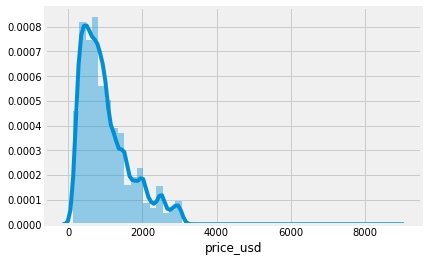

In [133]:
sns.distplot(listing_df['price_usd']);

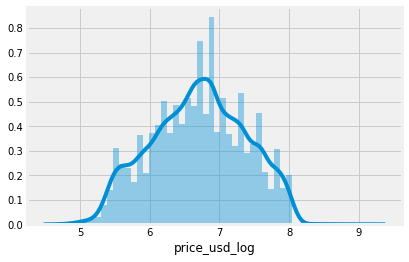

In [132]:
# Using the log I can normalize the plot a little bit 

sns.distplot(listing_df['price_usd_log']);

In [108]:
# Distance to Cape Town City Center

city_center = (-33.9249,18.4241)
listing_df['distance_cc'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(city_center, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)
# Distance VA Waterfront 

va_water = (-33.9036, 18.4205)
listing_df['distance_waterfront'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(va_water, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)

# Stellenbosch 

wine_lands = (-34.075691, 18.843266)
listing_df['distance_wine'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(wine_lands, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)

# Distance from Airport

airport = (-33.9249,18.4241)
listing_df['distance_airport'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(airport, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)


## 4. Statistical Testing

In [33]:
#Statistical Testing

In [34]:
# minimum nights > 4
# min nights < 4 
# mean min_nights is 3.93
# Prices of Air BNBs with less than 4 minimum nights is statistically different than houses with minimum nights greater or equal to 4. 
#2 sample ttest

stats.ttest_ind(listing_df[listing_df['minimum_nights'] >= 4]['price_usd_log'], listing_df[listing_df['minimum_nights'] < 4]['price_usd_log']) 



F_onewayResult(statistic=10.301412241737964, pvalue=0.001331716064438783)

In [35]:
# As we get closer the the City Center, the mean of the price changes. 
# ANOVA
# Combine testing needed


x = listing_df[listing_df['distance_cc'] >= 10]['price_usd_log']
y = listing_df[listing_df['distance_cc'] < 10]['price_usd_log']
ten_miles = stats.f_oneway(x, y)

x = listing_df[listing_df['distance_cc'] >= 8]['price_usd_log']
y = listing_df[listing_df['distance_cc'] < 8]['price_usd_log']
eight_miles = stats.f_oneway(x, y)

x = listing_df[listing_df['distance_cc'] >= 1]['price_usd_log']
y = listing_df[listing_df['distance_cc'] < 1]['price_usd_log']
one_mile = stats.f_oneway(x, y)

print('10 miles: ', ten_miles)
print('8 miles: ', eight_miles)
print('1 mile: ', one_mile)

10 miles:  F_onewayResult(statistic=3.5676551475236833, pvalue=0.05893220680422791)
8 miles:  F_onewayResult(statistic=10.562734536727625, pvalue=0.0011561144208251598)
1 mile:  F_onewayResult(statistic=91.55364227586814, pvalue=1.2290429745611808e-21)


In [126]:
# Independent T Test we can also see that the distance_cc is statistically different when looked over a mile to city center

ttest_distance_cc = stats.ttest_ind(listing_df[listing_df['distance_cc'] < 1]['price_usd_log'], listing_df[listing_df['distance_cc'] >=1]['price_usd_log']) 
ttest_distance_cc

Ttest_indResult(statistic=9.563862354430071, pvalue=1.2834654100460626e-21)

In [128]:
# H0 Price is not statistically contingent on the level of crime per 10,000
# H1 Price is statistically different based on the level of crime per 10,000

stats.ttest_ind(listing_df[listing_df['total_10000 _rounded_y'] >= 235.17]['price_usd'], listing_df[listing_df['total_10000 _rounded_y'] <235.17]['price_usd'])

# This one really shocked me. I thought for sure there would be a statistical different between the cost of the airbnb in areas with less crime per 10,000
# Failed to reject Null Hypothesis

Ttest_indResult(statistic=-0.42299170968349664, pvalue=0.6723065820183742)

In [129]:
# When price_usd_log is used, there is some statistical significance 

stats.ttest_ind(listing_df[listing_df['total_10000 _rounded_y'] >= 235.17]['price_usd_log'], listing_df[listing_df['total_10000 _rounded_y'] <235.17]['price_usd_log'])

Ttest_indResult(statistic=3.2875777934892887, pvalue=0.001012552851127008)

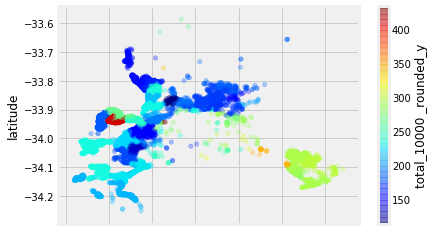

In [134]:

#listing_df.plot(kind= 'scatter', x = 'longitude', y = 'latitude', alpha = .3, c = 'total_10000 _rounded_y', cmap = plt.get_cmap('jet'));

## 5. Baseline model

In [130]:
# Baseline model; rmse:  669.5434143725225 r2:  0.0 using mean

subset = ['neighbourhood', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
x = listing_df[subset]
y = listing_df['price_usd_log']

dummy_regr = DummyRegressor(strategy = "mean")
dummy_regr.fit(x, y)
#DummyRegressor()
y_predict = dummy_regr.predict(y)
R2 = dummy_regr.score(x, y)

rmse = np.sqrt(metrics.mean_squared_error(y, y_predict))

print('rmse: ', rmse, 'r2: ', R2)

rmse:  0.6689703262230275 r2:  0.0


In [131]:
# Baseline model; rmse:  693.2896480095063 r2:  -0.07219047711717841 using median

subset = ['neighbourhood', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
x = listing_df[subset]
y = listing_df['price_usd_log']

dummy_regr = DummyRegressor(strategy = "median")
dummy_regr.fit(x, y)
#DummyRegressor()
y_predict = dummy_regr.predict(y)
R2 = dummy_regr.score(x, y)

rmse = np.sqrt(metrics.mean_squared_error(y, y_predict))

print('rmse: ', rmse, 'r2: ', R2)

rmse:  0.6692635305941289 r2:  -0.0008767761862580326


## 6. Test for Multi-Colinearity  

## 7. Model Testing